# Data Engineering Pipeline for License Plate Recognition

Here we will explore how to capture images from video streams and then use it to run different object detection models to obtain the objects with varying confidences

<b>Pre-requisites</b>: The notebook assumes that you have ffmpeg installed on the container or host where this notebook is running. If this is running on a container then make sure the container's docker file has the following installed namely <b>ffmpeg</b> and <b>tesseract</b>

```
apt-get update -qq && apt-get install ffmpeg -y
apt-get update -qq && apt-get install tesseract-ocr -y

```

We have also mapped the port <b>230002</b> to the container running the Jupyter notebook

In [1]:
!pip install numpy 
!pip install matplotlib
!pip uninstall -y opencv-python-headless
!pip uninstall -y opencv-python
!pip uninstall -y cv2
!pip uninstall -y pylabel
!pip install pylabel
!pip install opencv-python-headless
!pip install pytesseract
!pip install ffmpeg-python
!pip install python-Levenshtein

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Found existing installation: opencv-python-headless 4.9.0.80
Uninstalling opencv-python-headless-4.9.0.80:
  Successfully uninstalled opencv-python-headless-4.9.0.80
Found existing installation: opencv-python 4.9.0.80
Uninstalling opencv-python-4.9.0.80:
  Successfully uninstalled opencv-python-4.9.0.80
Found existing installation: pylabel 0.1.55
Uninstalling pylabel-0.1.55:
  Successfully uninstalled pylabel-0.1.55
  Using cached pylabel-0.1.55-py3-none-any.whl (27 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.6 MB)
You should consider upgr

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2 as cv
from pylabel import importer
from data_pipeline import Pipeline

# Initialize variables
data_folder = "/workspace/shared-data/license-plates/"
video_stream_url = "udp://127.0.0.1:23003"

# Initialize the pipeline - assumes that you have a "alpr-images" folder under license-plates 
# Assumes you have a "original" sub folder under "alpr-images" 
# Assumes you have a "cropped" sub folder under "alpr-images" for cropped images
# Assumes you have a "models" sub folder under "alpr-images" that has the Yolo3 models
pipeline = Pipeline(data_folder,video_stream_url)

Let's first initialize the <b>Pipeline</b> to extract and transform the data and to confirm we will load 1 image from the original directory and the cropped directory. <b>Note</b> After running this in the notebook I am starting a video stream as follows

```
ffmpeg -i LicensePlateReaderSample_4K.mov -qscale:v 2 -vcodec mpeg4 -f mpegts udp://127.0.0.1:23003

```
I have seen the following issues when running this from Jupyter notebook and will need more troubleshooting

<ul>
    <li>
        <b>High Resolution Images:</b>With High resolution images emitted with the -qscale:v 2 parameter the code is not able to save all the images (probably a timeout or bandwidth limit). When I remove that parameter it saves all the images
    </li>
    <li>
        <b>High Resolution Images:</b>Many of the images appear blurred and it is unclear what is causing this. 
    </li>
</ul>

The above issues are significantly pronounced when running it on this notebook which is itself running on the <b>jhebeler/classtank:705.603.jupyterlab </b> container

In [ ]:
# Perform the extract, transform and load
pipeline.extract()
pipeline.transform()
resized_img_list = pipeline.load()

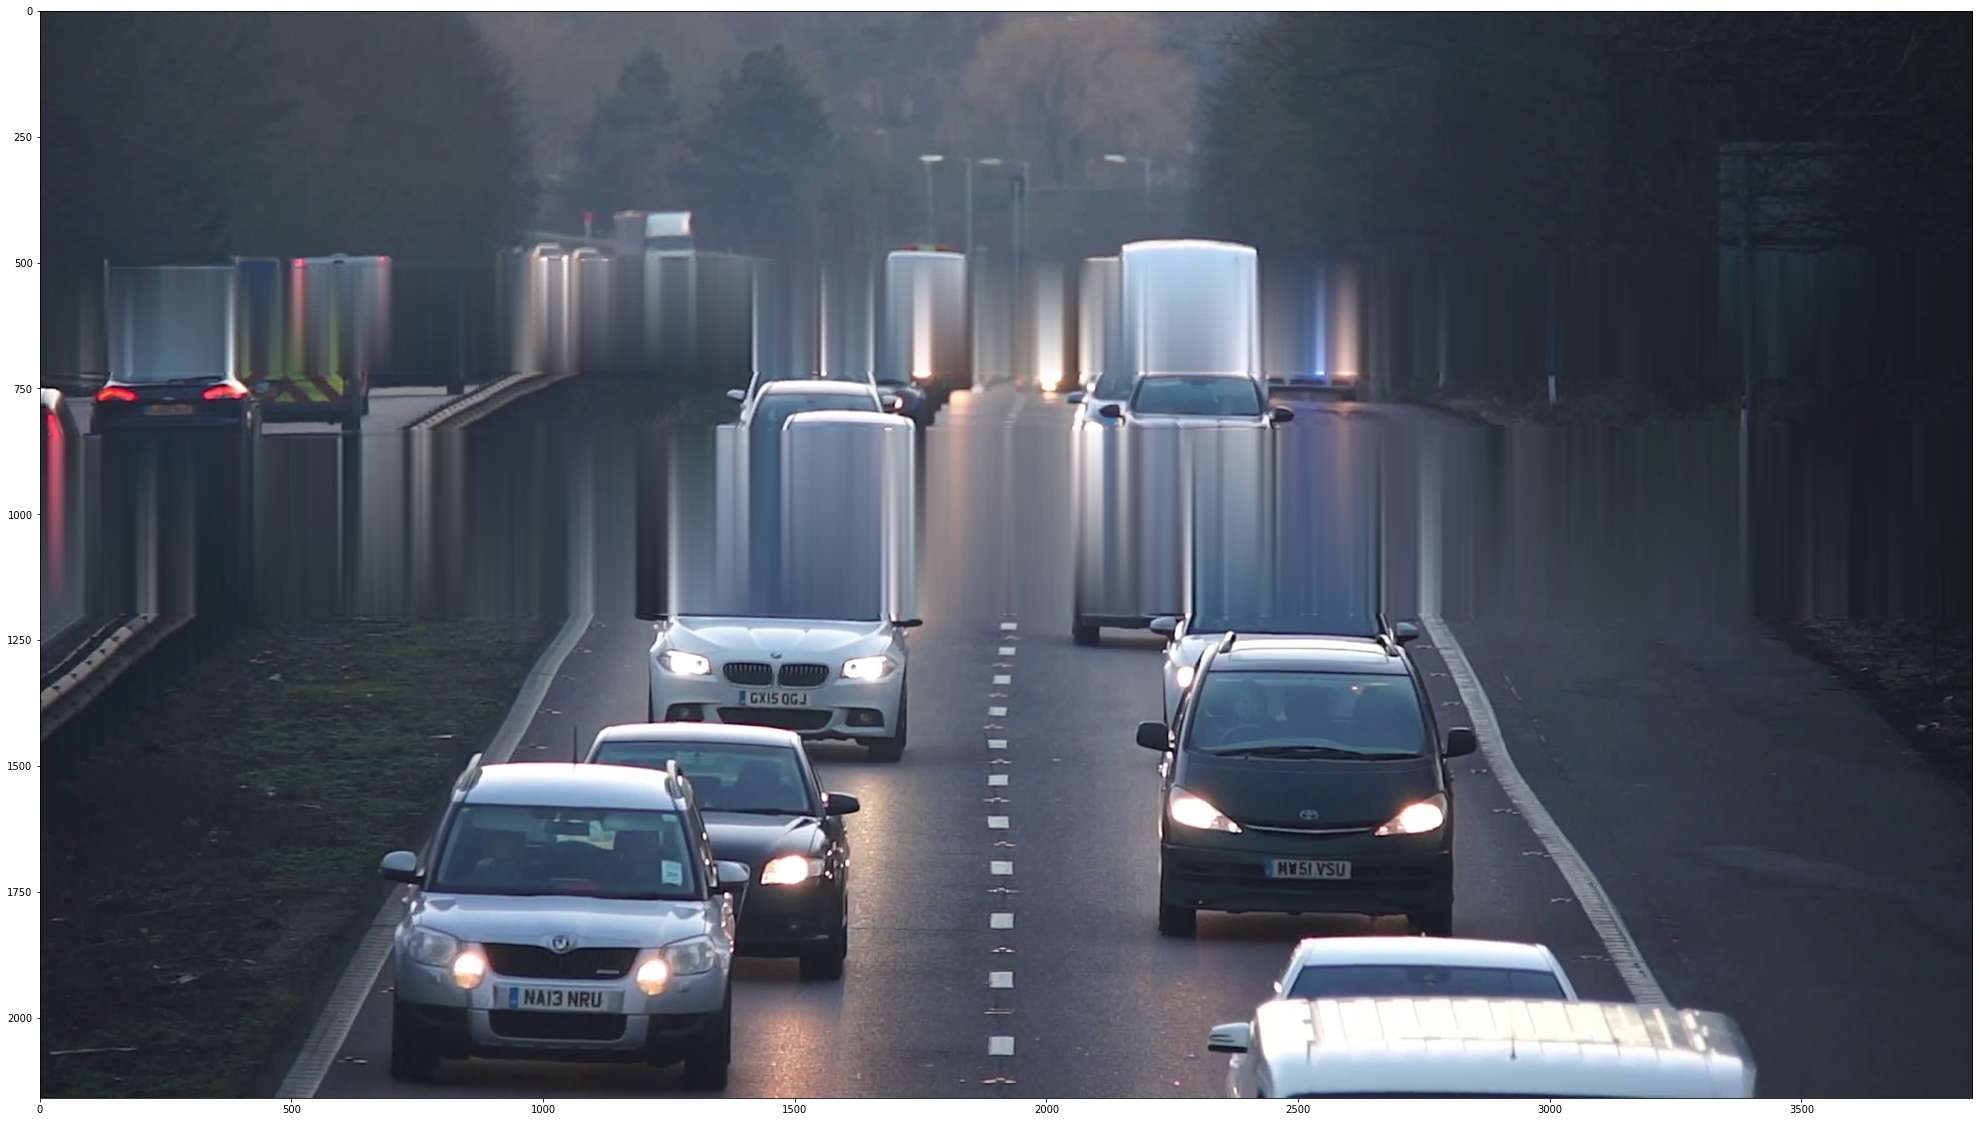

In [3]:
images_main_folder = "alpr-images/"
original_images_folder = "original/"
cropped_images_folder = "cropped/"
img = cv.imread(data_folder + images_main_folder + original_images_folder + '/image37.jpeg')
plt.figure(figsize = (100,20))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) 

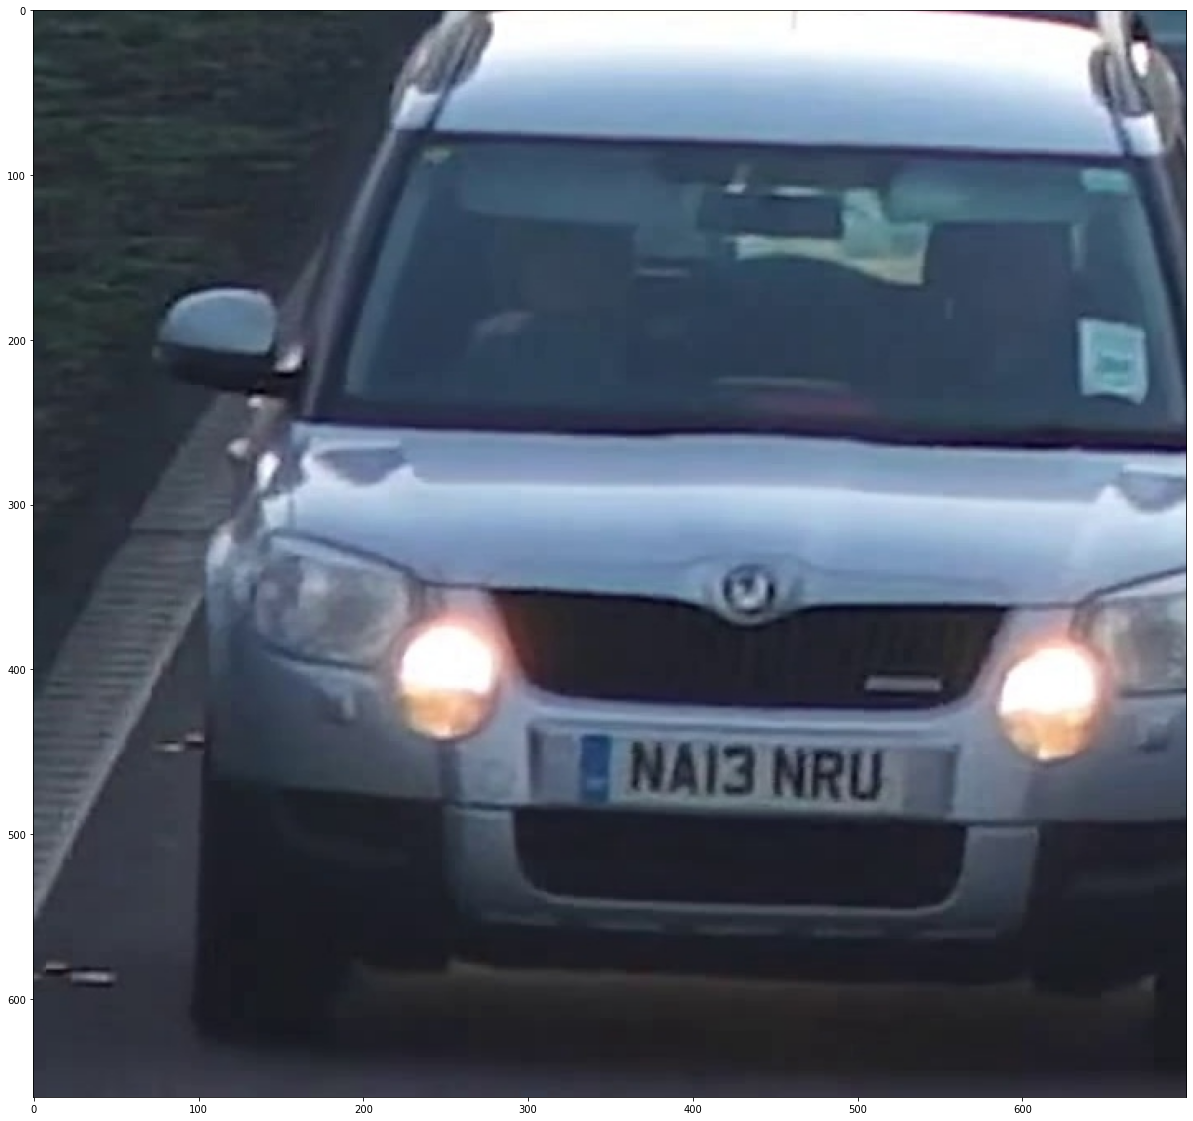

In [4]:
img = cv.imread(data_folder + images_main_folder + cropped_images_folder + '/image37_left.jpeg')
plt.figure(figsize = (100,20))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) 

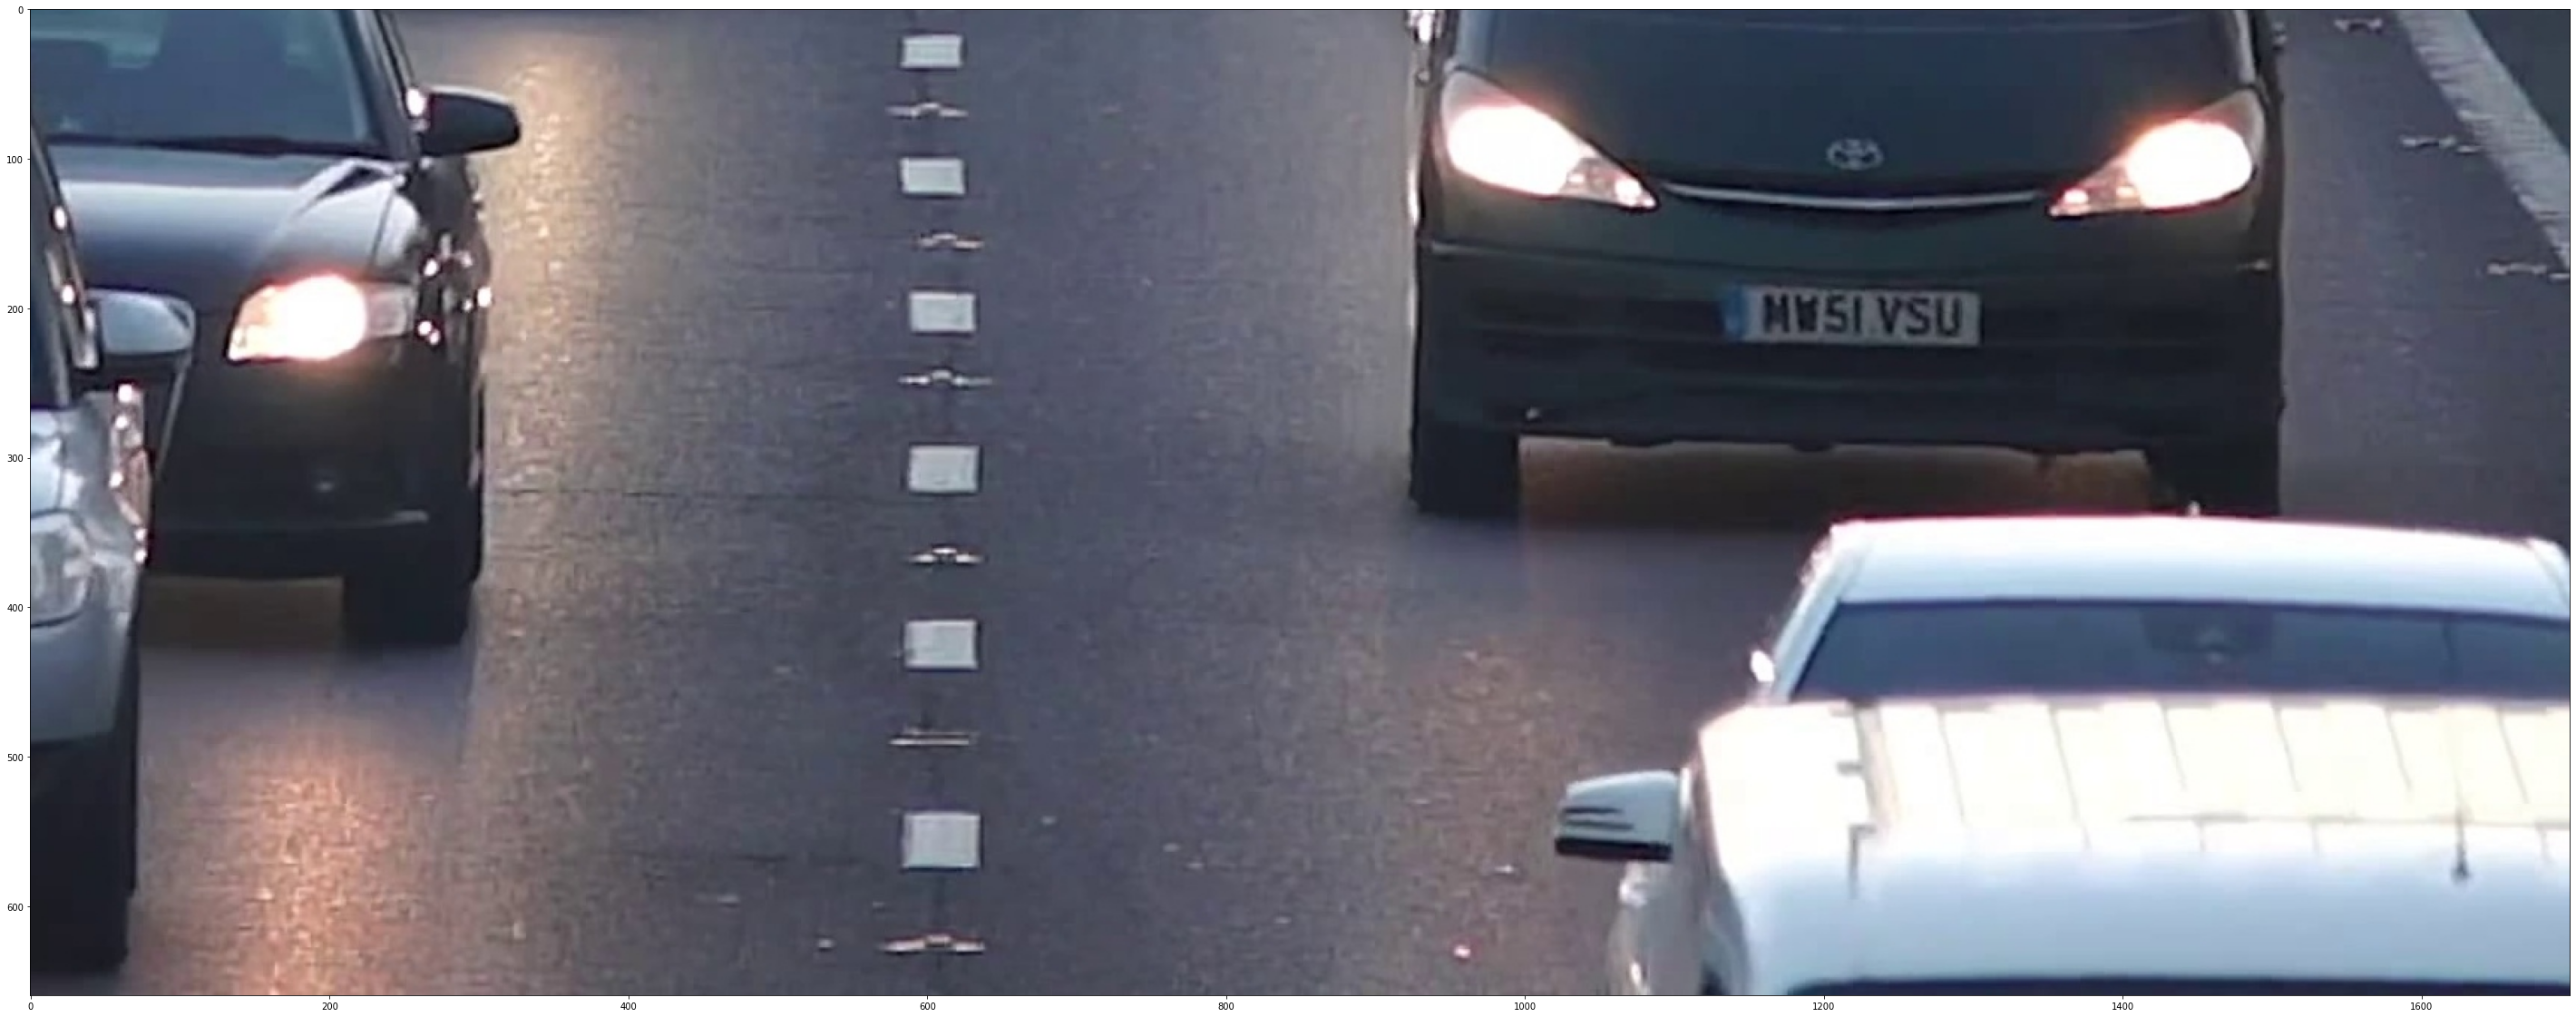

In [5]:
img = cv.imread(data_folder + images_main_folder + cropped_images_folder + '/image37_right.jpeg')
plt.figure(figsize = (100,20))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) 

We were able to load 109 images and we really have 2 license plates visible in these set of images namely 

<ul>
    <li>NAI3NRU</li>
    <li>MW5IVSU</li>
</ul>

We are generating 2 models below just to demonstrate the execution. right

In [6]:
from model import Object_Detection_Model

images_main_folder = "alpr-images/"

model_base_dir = data_folder + images_main_folder

model_left = Object_Detection_Model(cfg_file= "lpr-yolov3.cfg", weights_file='lpr-yolov3.weights', 
                                base_dir=model_base_dir, model_folder='models/', images_folder = 'NAI3NRU/')
model_right = Object_Detection_Model(cfg_file= "lpr-yolov3.cfg", weights_file='lpr-yolov3.weights', 
                                base_dir=model_base_dir, model_folder='models/', images_folder = 'MW5IVSU/')

As per our system design we have determined that the production system would need to make use of sensors to capture images related to entry and exit of vehicles from a certain point and to a certain point. Thus when we are cropping we are taking the images from that entry point. These images would all be associated with a tracking id and be stored under the folder/bucket for that id. Thus we would run our model on these set of images to perform bounding boxes and eventual OCR. 

For the purpose of the test, I have taken all the cropped images that have on <b>left lane</b> and put it inside of <b>NAI3NRU</b> folder. Similarly all <b>right lane</b> images put inside of <b>MW5IVSU</b>. Below we will form the image name arrays 

In [7]:
import os 

left_directory = model_base_dir + 'NAI3NRU/'
left_image_names = list()
for filename in os.listdir(left_directory):
    file_ext = filename.split('.')[1]
    if (file_ext == 'jpeg'):
        left_image_names.append(filename)

right_directory = model_base_dir + 'MW5IVSU/'
right_image_names = list()
for filename in os.listdir(right_directory):
    file_ext = filename.split('.')[1]
    if (file_ext == 'jpeg'):
        right_image_names.append(filename)

print(len(left_image_names))
print(len(right_image_names))

108
108


In [8]:
result_left = model_left.test('NAI3NRU',np.array(left_image_names))
print(result_left)

('NAI3NRU', 0, ['WA3NEU', 'BAISNRU', 'NAI3NRU', 'BNAINRU', 'VAI3NRU', 'FNAIZNRU', 'FUMINRU', 'WAINEU', 'FUMINRU', 'MAIWRU', '4NAI3NRU', 'NAI3NRU', 'NAI3NRU', 'NAI3NRU', 'BAISNRU', 'BAISNRU', 'NAI3NRU', 'ELIENRU', 'WACNELNEU', 'NAI3WRU', 'NAIZNRU', 'NAIZNRU', 'NAI3NRU', '1WA3NEU', 'NAI3NRU', 'NAI3NRU', 'VAI3NRU'])


In [9]:
result_right = model_right.test('MW5IVSU',np.array(right_image_names))
print(result_right)

('', 7, [])


Using the best predictions we are able to get the final license plate detected. We will now run this through our metrics to generate the overall report by passing each image

In [10]:
from metrics import Metrics

model_results = list()
model_results.append(result_left)
model_results.append(result_right)

metrics = Metrics()
metrics.generate_report(np.array(['NAI3NRU','MW5IVSU']),"reports/run1.txt", model_results)